In [ ]:
# fast_transfer_learning.py

import os, time
import numpy as np
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense, Dropout, Input, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ================= SETTINGS =================
DATA_DIR = r"c:\Users\saike\Downloads\medimg_py397\final_final_reduced"
ALEXNET_WEIGHTS = r"c:\Users\saike\Downloads\medimg_py397\alexnet\alexnet.h5"

IMG_SIZE = 128          
BATCH_SIZE = 64         
EPOCHS = 20             
# ============================================

# =============== LOAD DATA ==================
def load_data(path):
    X, y = [], []
    classes = sorted(os.listdir(path))
    for idx, c in enumerate(classes):
        for f in os.listdir(os.path.join(path, c)):
            img = cv2.imread(os.path.join(path, c, f), cv2.IMREAD_GRAYSCALE)
            if img is None: continue
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img / 255.0
            img = np.stack([img]*3, axis=-1)
            X.append(img)
            y.append(idx)
    return np.array(X), to_categorical(y), classes

X, Y, classes = load_data(DATA_DIR)
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, stratify=Y)

train_gen = ImageDataGenerator().flow(X_train, y_train, batch_size=BATCH_SIZE)

# =============== ALEXNET FEATURE EXTRACTION ==================
def alexnet_fast(input_shape, num_classes):
    i = Input(shape=input_shape)
    x = Conv2D(96, (11,11), strides=4, activation='relu', name="conv1")(i)
    x = MaxPooling2D((3,3), strides=2)(x)
    x = Conv2D(256, (5,5), padding='same', activation='relu', name="conv2")(x)
    x = MaxPooling2D((3,3), strides=2)(x)
    x = Conv2D(384, (3,3), padding='same', activation='relu', name="conv3")(x)
    x = MaxPooling2D((3,3), strides=2)(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    out = Dense(num_classes, activation='softmax')(x)

    model = Model(i, out)
    model.load_weights(ALEXNET_WEIGHTS, by_name=True, skip_mismatch=True)

    # 🔒 Freeze ALL conv layers
    for layer in model.layers:
        if isinstance(layer, Conv2D):
            layer.trainable = False

    return model

# =============== RESNET50 FEATURE EXTRACTION ==================
def resnet_fast(input_shape, num_classes):
    base = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
    base.trainable = False  # 🔒 fully frozen

    x = GlobalAveragePooling2D()(base.output)
    x = Dense(256, activation='relu')(x)
    out = Dense(num_classes, activation='softmax')(x)

    return Model(base.input, out)

# =============== TRAIN ==================
def train(model, name):
    model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    start = time.time()
    model.fit(train_gen, epochs=EPOCHS, validation_data=(X_val, y_val),
              callbacks=[EarlyStopping(patience=3)], verbose=1)
    t = round(time.time() - start, 2)
    loss, acc = model.evaluate(X_val, y_val, verbose=0)
    print(f"\n{name} → Acc: {acc:.4f}, Loss: {loss:.4f}, Time(s): {t}")
    return t, acc, loss

# =============== RUN ==================
alex = alexnet_fast((IMG_SIZE, IMG_SIZE, 3), len(classes))
train(alex, "AlexNet_Fast_TL")

resnet = resnet_fast((IMG_SIZE, IMG_SIZE, 3), len(classes))
train(resnet, "ResNet50_Fast_TL")


c:\Users\saike\anaconda3\envs\medimg_py397\lib\site-packages\keras\src\legacy\saving\legacy_h5_format.py:513: UserWarning: Skipping loading weights for layer #3 (named conv2)due to mismatch in shape for weight conv2/kernel. Weight expects shape (5, 5, 96, 256). Received saved weight with shape (5, 5, 48, 256)
  _set_weights(
c:\Users\saike\anaconda3\envs\medimg_py397\lib\site-packages\keras\src\legacy\saving\legacy_h5_format.py:513: UserWarning: Skipping loading weights for layer #13 (named dense)due to mismatch in shape for weight dense/kernel. Weight expects shape (1536, 256). Received saved weight with shape (4096, 1000)
  _set_weights(
c:\Users\saike\anaconda3\envs\medimg_py397\lib\site-packages\keras\src\legacy\saving\legacy_h5_format.py:513: UserWarning: Skipping loading weights for layer #13 (named dense)due to mismatch in shape for weight dense/bias. Weight expects shape (256,). Received saved weight with shape (1000,)
  _set_weights(
c:\Users\saike\anaconda3\envs\medimg_py397\

Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 34s 223ms/step - accuracy: 0.4634 - loss: 1.2292 - val_accuracy: 0.7304 - val_loss: 0.8260
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 157ms/step - accuracy: 0.7237 - loss: 0.7874 - val_accuracy: 0.7414 - val_loss: 0.6610
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 157ms/step - accuracy: 0.7563 - loss: 0.6266 - val_accuracy: 0.7414 - val_loss: 0.6217
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 23s 160ms/step - accuracy: 0.7647 - loss: 0.5848 - val_accuracy: 0.7854 - val_loss: 0.5371
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 155ms/step - accuracy: 0.7938 - loss: 0.5125 - val_accuracy: 0.7757 - val_loss: 0.5303
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 191ms/step - accuracy: 0.7960 - loss: 0.5058 - val_accuracy: 0.7801 - val_loss: 0.5096
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 149ms/step - accuracy: 0.7933 - loss: 0.4916 - val_accuracy: 0.8083 - val_loss: 0.4579
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 31s 215ms/step - accuracy: 0.8056 - loss: 0

(3112.02, 0.728232204914093, 0.6407392621040344)


================ FINAL MODEL RESULTS ==================

             Model   Params  Val_Accuracy  Val_Loss  Train_Time_sec
        AlexNet_TL 46763396        0.8215    0.4198          394.00
       ResNet50_TL 24638852        0.7282    0.6407         3112.00
CustomCNN_Baseline  1131428        0.9825    0.0737         1671.84



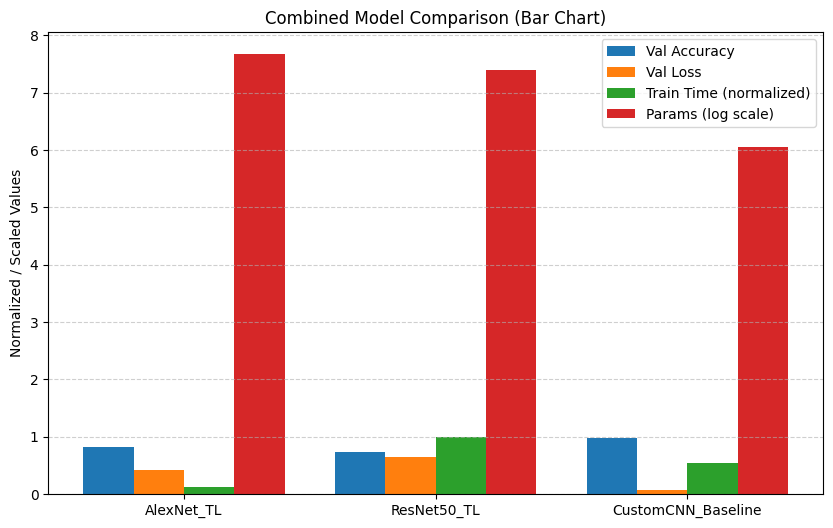

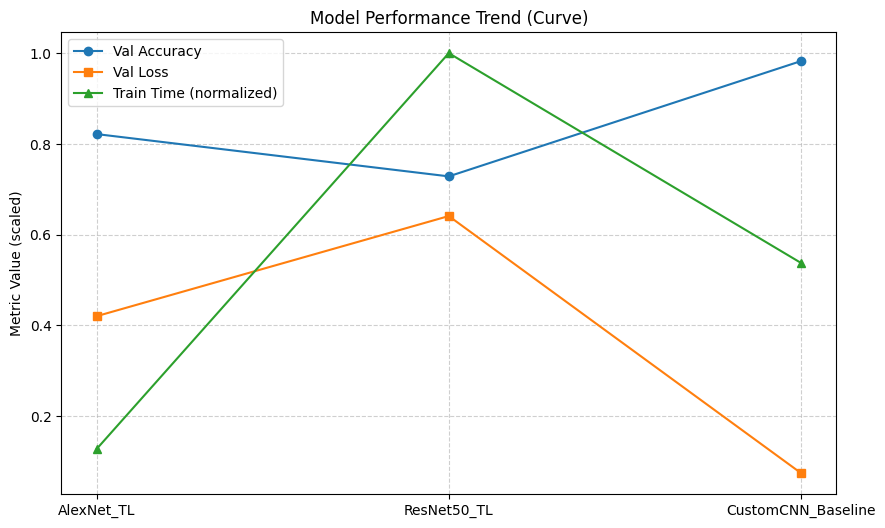

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ================= GIVEN RESULTS =================
results = [
    {
        "Model": "AlexNet_TL",
        "Params": 46763396,
        "Val_Accuracy": 0.8215,
        "Val_Loss": 0.4198,
        "Train_Time_sec": 394
    },
    {
        "Model": "ResNet50_TL",
        "Params": 24638852,
        "Val_Accuracy": 0.7282,
        "Val_Loss": 0.6407,
        "Train_Time_sec": 3112
    },
    {
        "Model": "CustomCNN_Baseline",
        "Params": 1131428,
        "Val_Accuracy": 0.9825,
        "Val_Loss": 0.0737,
        "Train_Time_sec": 1671.84
    }
]
# =================================================

# ================= DATAFRAME =================
df = pd.DataFrame(results)

print("\n================ FINAL MODEL RESULTS ==================\n")
print(df[["Model", "Params", "Val_Accuracy", "Val_Loss", "Train_Time_sec"]]
      .to_string(index=False))
print("\n======================================================")

models = df["Model"]
x = np.arange(len(models))

# ================= 1️⃣ BAR CHART (COMBINED) =================
plt.figure(figsize=(10, 6))

plt.bar(x - 0.3, df["Val_Accuracy"], width=0.2, label="Val Accuracy")
plt.bar(x - 0.1, df["Val_Loss"], width=0.2, label="Val Loss")
plt.bar(x + 0.1, df["Train_Time_sec"] / max(df["Train_Time_sec"]), 
        width=0.2, label="Train Time (normalized)")
plt.bar(x + 0.3, np.log10(df["Params"]), width=0.2, label="Params (log scale)")

plt.xticks(x, models)
plt.ylabel("Normalized / Scaled Values")
plt.title("Combined Model Comparison (Bar Chart)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# ================= 2️⃣ CURVE (LINE) GRAPH =================
plt.figure(figsize=(10, 6))

plt.plot(models, df["Val_Accuracy"], marker="o", label="Val Accuracy")
plt.plot(models, df["Val_Loss"], marker="s", label="Val Loss")
plt.plot(models, df["Train_Time_sec"] / max(df["Train_Time_sec"]),
         marker="^", label="Train Time (normalized)")

plt.ylabel("Metric Value (scaled)")
plt.title("Model Performance Trend (Curve)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()
